# ITR 2
## Author: Ashlynn Wimer
## Date: 11/14/2024
## Method: Graph Data Mining Embeddings
Prior literature on traffic safety typically makes use of street networks in some way, but rarely makes use of network embeddings or attempts to make predictions based on network characteristics. In fact, the newest paper I was able to find directly using network methods for traffic safety was by Sarkar et al. (2018), and focused on understanding the relationship between betweenness, divergence ratio, and hull radius with the odds of severe traffic injury. Expanding the search to fields adjacent to traffic safety yields more exploration but a lack of unified methods. Wang et al. (2019) develop IRN2Vec, an intersection embedding model which they use for missing tag prediction and travel time estimation. Notably, this model specifically embeds intersections, making it less useful for road safety due the roads between intersections being of potential interest. This seemingly prompted an expansion, as in the next year Wang et al. (2020) developed a broader embedding method known as Road Network to Vector (RN2Vec) which incorporated their IRN2Vec as one of its three internal embeddings. The authors once again test this embedding against trave time prediction, finding it performs better than other embedding methods. Gu et al. (2024) use three embedding techniques – DeepWalk on the dual graph of a street network, a one-hot encoding method, and a relational graph convolution network method – on street network attributes, the network itself, and heavily preprocessed point of interest data to predict burglary and pickpocketing.

Based on this brief literature review, there seems to be interest in the development of road network embeddings, but less interest in applying their usage to traffic safety prediction. Additionally, what interest there is usually stays at the street network level, with all surveyed embedding approaches staying at this scale instead of moving to community level. This leaves a gap in our understanding of the extent to which street network topology – as opposed to street network attributes – influence traffic safety outcomes at the community level. We aim to fill this gap in methodological research by testing the performance of a classic network embedding method – Node2Vec – for predicting traffic crash counts at the census tract level.
methods

We embark upon a preliminary investigation of the potential of network embeddings to capture traffic safety factors in New York City at the Census Tract level. For our approach, we utilize Node2Vec to embed the 2020 street network of New York City as retrieved from OSM, before creating subgraph embeddings for each Census Tract in the city, and then using multiple machine learning algorithms – primarily RF, SVD, and linear regression – to test the ability of our resultant embeddings to predict traffic crash data.


In [3]:
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
# !pip install -q pyogrio pyarrow geopandas
# !pip install -q osmnx

import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q osmnx pyogrio pyarrow geopandas

2.5.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 110.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 79.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 40.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.3 MB/s eta 0:00:00


In [109]:
from torch_geometric.nn import Node2Vec
import pickle
import sys
import geopandas as gpd
import torch
from torch import Tensor
from osmnx import graph_from_gdfs
from torch_geometric.nn import Node2Vec
import networkx as nx
from torch_geometric.data import Data
from collections import defaultdict
from torch import tensor
import torch_cluster
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression
from numpy.linalg import norm
import pandas as pd

from matplotlib import pyplot as plt


### Helper Functions
(we have so many)

In [5]:
# list of tracts that are over waterways or otherwise not relevant to this analysis
# excluded
EXCLUDED_TRACTS = ['36005051602', '36061000100']

def from_osmnx(G, nodes_gdf, edges_gdf, group_node_attrs=None, group_edge_attrs=None):
    '''
    Converts osmnx graph or digraph to torch_geometric.data.Data objects.
    Based nearly entirely on torch.geometry.utils.convert.from_networkx,
    but with modifications for this specific project.
    Args:
      G (networkx.Graph or networx.DiGraph): A networkx graph
      nodes_gdf (GeoDataFrame): the initial gdf of nodes.
      edges_gdf (GeoDataFrame)L the initial gdf of edges.
      group_node_attrs (List[str], "all", or None): The node attributes to be
        concatenated and added to data.x (defaults to None)
      group_edge_attrs (List[str], "all", or None): The edge attributes to be
        concatenated and added to data.edge_attr. Defaults to None.
       All attributes must be numeric (woe)
    '''

    G = G.to_directed() if not nx.is_directed(G) else G

    mapping = dict(zip(G.nodes(), range(G.number_of_nodes())))
    edge_index = torch.empty((2, G.number_of_edges()), dtype=torch.long)
    for i, (src, dst) in enumerate(G.edges()):
        edge_index[0, i] = mapping[src]
        edge_index[1, i] = mapping[dst]

    data_dict = defaultdict(list)
    data_dict['edge_index'] = edge_index

    node_attrs = []
    if G.number_of_nodes() > 0:
        node_attrs = list(next(iter(G.nodes(data=True)))[-1].keys())

    edge_attrs = []
    if G.number_of_edges() > 0:
        edge_attrs = list(next(iter(G.edges(data=True)))[-1].keys())

    if group_node_attrs and not isinstance(group_node_attrs, list):
        group_node_attrs = node_attrs

    if group_edge_attrs and not isinstance(group_edge_attrs, list):
        group_edge_attrs = edge_attrs

    # Main change from the initial from_networkx function are these
    # two chunks. Instead of raising an error, they now just
    # reference my initial GDFs, since I can do that.
    for i, (_, feat_dict) in enumerate(G.nodes(data=True)):
        if set(feat_dict.keys()) != set(node_attrs):
            feat_dict = {}
            print(f"Correcting dropped node values for row {i}")
            for k in node_attrs:
                feat_dict[k] = nodes_gdf.iloc[i].get(k)
        for key, value in feat_dict.items():
            data_dict[str(key)].append(value)

    for i, (_, _, feat_dict) in enumerate(G.edges(data=True)):
        if set(feat_dict.keys()) != set(edge_attrs):
            feat_dict = {}
            print(f"Correcting dropped edge values for row {i}")
            for k in edge_attrs:
                feat_dict[k] = edges_gdf.iloc[i].get(k)
        for key, value in feat_dict.items():
            key = f'edge_{key}' if key in node_attrs else key
            data_dict[str(key)].append(value)

    for key, value in G.graph.items():
        if key == 'node_default' or key == 'edge_default':
            continue
        key = f'graph_{key}' if key in node_attrs else key
        data_dict[str(key)] = value

    for key, value in data_dict.items():
        if isinstance(value, (tuple, list)) and isinstance(value[0], Tensor):
            data_dict[key] = torch.stack(value, dim=0)
        else:
            try:
                data_dict[key] = torch.as_tensor(value)
            except Exception:
                pass

    data = Data.from_dict(data_dict)

    if group_node_attrs:
        xs = []
        for key in group_node_attrs:
            x = data[key]
            print(x)
            x = x.view(-1, 1) if x.dim() <= 1 else x
            xs.append(x)
            del data[key]
        data.x = torch.cat(xs, dim=-1)

    if group_edge_attrs:
        xs = []
        for key in group_edge_attrs:
            key = f'edge_{key}' if key in node_attrs else key
            x = data[key]
            x = x.view(-1, 1) if x.dim() <= 1 else x
            xs.append(x)
            del data[key]
        data.edge_attr = torch.cat(xs, dim=-1)

    if data.x is not None and data.pos is not None:
        data.num_nodes = G.number_of_nodes()

    return data


def setup_model(data):
    '''
    Setup our model. Returns model, loader, optimizer, device as a tuple.
    '''
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = Node2Vec(
        data.edge_index,
        embedding_dim=128,
        walk_length=20,
        context_size=10,
        walks_per_node=10,
        num_negative_samples=1,
        p=1.0,
        q=1.0,
        sparse=False
    ).to(device)

    num_workers = 4 if sys.platform == 'linux' else 0
    loader = model.loader(batch_size=129, shuffle=True, num_workers=num_workers)
    optimizer = torch.optim.Adam(list(model.parameters()), lr=0.01)

    return model, loader, optimizer, device

def read_in_graphs(edges_loc="../../data/shapes/newyork_edges_2020.gpkg",
                   nodes_loc="../../data/shapes/newyork_nodes_2020_split.gpkg"):
    '''
    Read in graph data, using assumed file names and locations, and return
    both the pytorch graph and a dataset mapping from GEOIDs to graph indices.

    Defaults are based on my github repo.
    '''

    def add_geoid_to_dict(geoid_dict, geoid, i):
        '''
        Helper function which adds a new value to a dict.
        '''
        if not geoid in geoid_dict.keys():
            geoid_dict[geoid] = []
        geoid_dict[geoid].append(i)

        return geoid_dict

    edges = gpd.read_file(edges_loc, engine='pyogrio', use_arrow=True)
    edges = edges.set_index(['u', 'v', 'key'])
    nodes = gpd.read_file(nodes_loc, engine='pyogrio', use_arrow=True)
    nodes = nodes.set_index(['osmid'])
    nodes = nodes.drop_duplicates()
    G = graph_from_gdfs(nodes[['y', 'x', 'GEOID']], edges[['geometry']])

    # We need this in pytorch's graph format
    data = from_osmnx(G, nodes, edges)

    # make dict
    # above process was order preserving
    geoid_dict = {}
    for i, val in enumerate(G.nodes):
        try:
            geoid = nodes.loc[val].get('GEOID')
        except KeyError:
            print(f'KeyError on OSMID {val}.')
        if not type(geoid) in [int, str]:
            for g in geoid:
                geoid_dict = add_geoid_to_dict(geoid_dict, g, i)
            continue

        geoid_dict = add_geoid_to_dict(geoid_dict, geoid, i)

    del data.GEOID

    return data, geoid_dict

def get_crashes_by_tract(train_test=False, power_scale=False):
    '''
    Get train and test crash counts by tract for downstream tasks.
    Returns a presplit tuple if train_test is True, and power scales
    the counts if power_scale is True.
    '''
    # Read in tracts
    tracts = gpd.read_file('nyc_tracts.shp').to_crs('EPSG:2263')
    tracts = tracts[tracts['ALAND'] != 0]
    tracts = tracts[~tracts['GEOID'].isin(EXCLUDED_TRACTS)]
    crashes = gpd.read_file('crashes.shp').to_crs('EPSG:2263')

    # Take counts
    tract_crashes = gpd.sjoin(tracts, crashes, how='left', predicate='contains')
    tract_crashes = tract_crashes[['GEOID']].value_counts().reset_index()

    if power_scale:
        tract_crashes['count'] = PowerTransformer('box-cox')\
                                    .fit_transform(tract_crashes[['count']])

    if train_test:
        X_train, X_test, y_train, y_test = \
          train_test_split(tract_crashes.GEOID, tract_crashes['count'], test_size=0.2)

        return X_train, X_test, y_train, y_test

    return tract_crashes

def make_subgraph_embedding(z, indices, n_nodes=180018):
    '''
    Given a Node2Vec embedding model and the indices of relevant
    node embeddings, return the subgraph embedding as a numpy array.
    '''
    mask = torch.zeros(n_nodes, dtype=torch.bool)

    for ind in indices:
        mask[ind] = True

    # Take sum of nodes in subgraph
    rel = z[mask]
    rel_sum = rel.detach().cpu().numpy().sum(axis=0)
    unit = rel_sum / norm(rel_sum)
    # Return norm of sum as subgraph vector
    return unit

def train(model, loader, optimizer, device):
    '''
    Train node2vec model
    '''
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def test(model, data, geoid_dict, train_test):
    '''
    Test model accuracy against regression prediction task. Returns RMSE error.
    '''
    from sklearn.linear_model import LinearRegression

    GEOID_train, GEOID_test, y_train, y_test = train_test
    model.eval()
    z = model()

    train_geoids, train_embeds = [], []
    for geoid in GEOID_train:
        train_geoids.append(geoid)
        train_embeds.append(make_subgraph_embedding(z, geoid_dict[geoid]))

    test_geoids, test_embeds = [], []
    for geoid in GEOID_test:
        test_geoids.append(geoid)
        test_embeds.append(make_subgraph_embedding(z, geoid_dict[geoid]))

    X_test = pd.DataFrame(test_embeds, index=test_geoids)
    X_train = pd.DataFrame(train_embeds, index=train_geoids)

    reg = LinearRegression().fit(X_train, y_train)

    return reg.score(X_test, y_test)


### Embedding!

In [ ]:
data, geoid_dict = read_in_graphs(nodes_loc='newyork_nodes_2020_split.gpkg',
                                  edges_loc='newyork_edges_2020.gpkg')

NameError: name 'gpd' is not defined

Weird that we have keyerrors, but they aren't too concerning given the size of the dataset (we have _many_ nodes). Additioanlly, investigation of them hints that they're the result of some weirdness in the `graphs_from_gdfs` function, as those OSMIDs do not appear in the initial geodataframe.

In [ ]:
train_test = get_crashes_by_tract(True, True)

In [ ]:
model, loader, optimizer, device = setup_model(data)

# These result losses and epochs are left here for posterity, but I ran this like. Twice?
# After the actual to be used weights. Those weights achieved a loss closer to
# 0.73ish and an accuracy of about ~.11ish, using the same model settings.
# I have no clue why these weights are underperforming so.
for epoch in range(1, 101):
    loss = train(model, loader, optimizer, device)
    acc = test(model, data, geoid_dict, train_test)
    print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, acc: {acc:.4f}")

Epoch: 001, Loss: 7.0665, acc: -0.1077
Epoch: 002, Loss: 2.6472, acc: -0.0775
Epoch: 003, Loss: 1.0931, acc: -0.0451
Epoch: 004, Loss: 0.8162, acc: -0.0122
Epoch: 005, Loss: 0.7862, acc: -0.0348
Epoch: 006, Loss: 0.8007, acc: -0.0334
Epoch: 007, Loss: 0.8093, acc: 0.0199


Our resultant model doesn't appear to be _too_ good at predicting, at least based on the current measures. Still, we have a few things we can play with!

But, first, let's make it so we can actaully walk away from the computer without needing to rerun the above chunk.

In [ ]:
# Save for future work (or for re-loading my progress!)
from google.colab import files

torch.save(model.state_dict(), 'node2vec_no_att')
files.download('node2vec_no_att')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
# Reload to pick up where we left off!
data, geoid_dict = read_in_graphs(nodes_loc='newyork_nodes_2020_split.gpkg',
                                  edges_loc='newyork_edges_2020.gpkg')

model, loader, optimizer, device = setup_model(data)
model.load_state_dict(torch.load('node2vec_no_att(1)', weights_only=True))

tract_crashes = get_crashes_by_tract()

Correcting dropped node values for row 23827
Correcting dropped node values for row 25307
Correcting dropped node values for row 32082
Correcting dropped node values for row 34282
Correcting dropped node values for row 36114
Correcting dropped node values for row 52781
Correcting dropped node values for row 56907
Correcting dropped node values for row 60442
Correcting dropped node values for row 62559
Correcting dropped node values for row 76926
Correcting dropped node values for row 76928
Correcting dropped node values for row 79172
Correcting dropped node values for row 83002
Correcting dropped node values for row 87384
Correcting dropped node values for row 87385
Correcting dropped node values for row 101781
Correcting dropped node values for row 101789
Correcting dropped node values for row 105823
Correcting dropped node values for row 116074
Correcting dropped node values for row 116075
Correcting dropped node values for row 116076
Correcting dropped node values for row 142529
Cor

With our data in, we can start playing with predictive tasks. We play with a few different models for two types of task: regression against the total number of crashes, and hotspot classification.

In [7]:
import numpy as np

We start by setting up our data for these tasks, and building a few useful helper functions so we can avoid having to constantly rewrite code.


In [9]:
# merge in spatial for easier ESDA
nyc_tracts = gpd.read_file('nyc_tracts.shp')
nyc_tracts = nyc_tracts[['GEOID', 'geometry']]
nyc_tracts['GEOID'] = nyc_tracts.GEOID.astype(object)
tract_crashes2 = nyc_tracts.merge(tract_crashes, on='GEOID', how='right')

# create subgraph vectors [our features!]
model.eval()
z = model()

geoids, embeds = [], []
for geoid in tract_crashes2.GEOID:
    geoids.append(geoid)
    embeds.append(make_subgraph_embedding(z, geoid_dict[geoid]))

embed_pd = pd.DataFrame(np.array(embeds), index=geoids).reset_index()
embed_pd = embed_pd.rename({'index':'GEOID'}, axis=1)
tract_crashes2 = tract_crashes2.merge(embed_pd, on='GEOID', how='left')


In [49]:
!pip -q install contextily

In [77]:
import contextily as cx

def regress_on_counts(data, model):
    '''
    Run a regression model on our data, and return a copy of the dataframe
    with predicted values and the model.
    '''
    pt = PowerTransformer()

    data_used = data.copy()
    data_used['log_count'] = pt.fit_transform(data_used[['count']])

    X_train, X_test, y_train, y_test = train_test_split(
        data_used.set_index("GEOID").drop(['geometry', 'count', 'log_count'], axis=1),
        data_used.set_index('GEOID')['log_count'],
        train_size=0.8
    )

    model.fit(X_train, y_train)
    print(f"Model Scored {model.score(X_test, y_test)}")

    data_used['pred'] = model.predict(data_used.drop(['GEOID', 'geometry', 'count', 'log_count'], axis=1))
    data_used['error'] = data_used['pred'] / data_used['log_count']

    return data_used, model

def classify_hotspots(data, model, quantile=0.9):
    '''
    Attempt to classify hotspots via a given model and data. Returns
    a copy of the dataframe with predicted values and the model
    '''

    # Feature creation
    data_used = data.copy()
    data_used['hotspot'] = data_used['count'] >= data_used['count'].quantile(quantile)

    # Data split
    X_train, X_test, y_train, y_test = train_test_split(
        data_used.set_index('GEOID').drop(['geometry', 'count', 'hotspot'], axis=1),
        data_used.set_index('GEOID')['hotspot'],
        train_size=0.8
    )

    model.fit(X_train, y_train)
    print(f"Model Scored {model.score(X_test, y_test)}")

    data_used['pred'] = model.predict(data_used.drop(['GEOID', 'geometry', 'count', 'hotspot'], axis=1))
    data_used['error'] = data_used['pred'].astype(int) - data_used['hotspot'].astype(int)

    rewrite = {-1: 'false_positive', 0:'correct prediction', 1:'false_negative'}

    data_used['error'] = data_used['error'].apply(lambda x: rewrite[x])

    return data_used, model

def map_data_prettierish(data, error=False):
    '''
    Map the data, but prettier.. ish.

    Inputs:
        data (GeoDataFrame): data to be plotted, should have 'error' and
          'pred' features.
        error (bool): whether to plot errors or raw predictions.

    Returns: None. Makes map
    '''
    fig, ax = plt.subplots()

    variable = 'error' if error else 'pred'
    title = 'Prediction Error' if error else 'Predicted Values'

    data.plot(variable, legend=True, ax=ax, alpha=0.9)

    cx.add_basemap(ax, crs=data.crs)
    plt.title(title)
    ax.set_axis_off()

Model Scored 0.13645234245601878


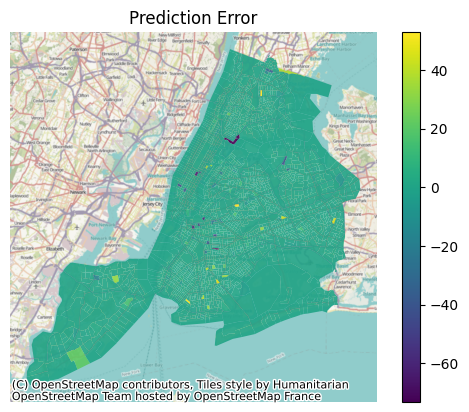

In [63]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import PowerTransformer

ridge = RidgeCV()
crash_preds, _ = regress_on_counts(tract_crashes2, ridge)

map_data_prettierish(crash_preds, error=True)

Let's play with a few models:

In [79]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Model Scored 0.1257000747369309
RF Best Params: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}


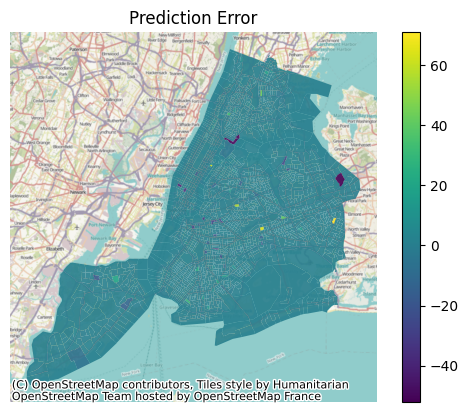

In [78]:
param_grid_rf = {
    'n_estimators': [200, 400, 600, 800, 1000, 1200],
    'max_depth': [5, 10, 20, 30, 40, 50],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'max_features': ['log2', 'sqrt']
}

# Randomized search because I have no clue what parameters I want
# but I also don't want to wait here for as long as a it takes to
# fit 6 * 6 * 3 * 3 * 2 * 3 models!
rf = RandomForestRegressor()
rscv = RandomizedSearchCV(estimator=rf,
                          param_distributions=param_grid_rf,
                          n_iter=100, cv=3, verbose=2, n_jobs=-1)

crash_preds, fit_rscv = regress_on_counts(tract_crashes2, rscv)

print(f'RF Best Params: {fit_rscv.best_params_}')

map_data_prettierish(crash_preds, error=True)

That was an amusing amount of runtime for not the most improvement in predictive power. Maybe a different model?

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Model Scored 0.18551107971456893
RF Best Params: {'n_estimators': 200, 'max_depth': 7, 'loss': 'absolute_error', 'learning_rate': 0.05}


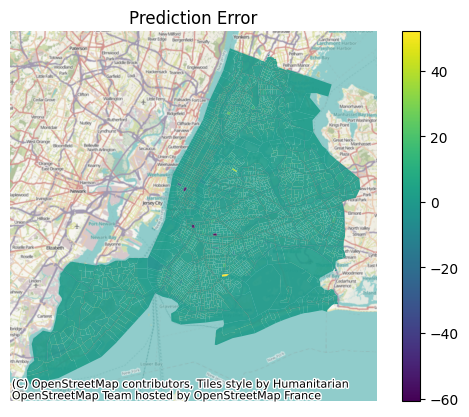

In [83]:
param_grid_gb = {
  'loss': ['squared_error', 'absolute_error', 'huber'],
  'learning_rate': [0.05, 0.075, 0.1],
  'n_estimators': [100, 150, 200, 300, 500],
  'max_depth': [1, 3, 5, 7]
}

gb = GradientBoostingRegressor()
rscv = RandomizedSearchCV(estimator=gb,
                          param_distributions=param_grid_gb,
                          n_iter=100, cv=3, verbose=2, n_jobs=-1)

crash_preds, fit_rscv = regress_on_counts(tract_crashes2, rscv)

print(f'RF Best Params: {fit_rscv.best_params_}')

map_data_prettierish(crash_preds, error=True)

Model Scored 0.886021505376344


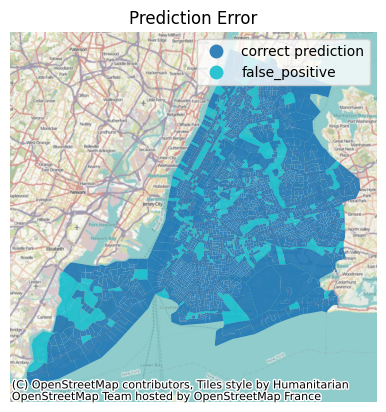

In [69]:
from sklearn.linear_model import LogisticRegressionCV

logr = LogisticRegressionCV(Cs=15, solver='lbfgs')
hotspot_preds, _ = classify_hotspots(tract_crashes2, logr)

map_data_prettierish(hotspot_preds, error=True)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Model Scored 0.8946236559139785
RF Best Params: {'n_estimators': 100, 'max_depth': 5, 'loss': 'exponential', 'learning_rate': 0.05}


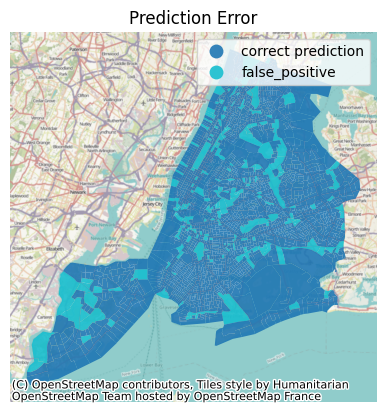

In [85]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gb = {
  'loss': ['exponential', 'log_loss'],
  'learning_rate': [0.05, 0.075, 0.1],
  'n_estimators': [100, 150, 200, 300, 500],
  'max_depth': [1, 3, 5, 7]
}

gb = GradientBoostingClassifier()
rscv = RandomizedSearchCV(estimator=gb,
                          param_distributions=param_grid_gb,
                          n_iter=100, cv=3, verbose=2, n_jobs=-1)

crash_preds, fit_rscv = classify_hotspots(tract_crashes2, rscv)

print(f'RF Best Params: {fit_rscv.best_params_}')

map_data_prettierish(crash_preds, error=True)

89% overall accuracy on hotspot prediction is pretty good! However, we seem to never false negative, and we've given it one of the easier versions of this prediction task. In particular, crash quantiles look something like:

Text(0.5, 1.0, 'Traffic Crash Count Density')

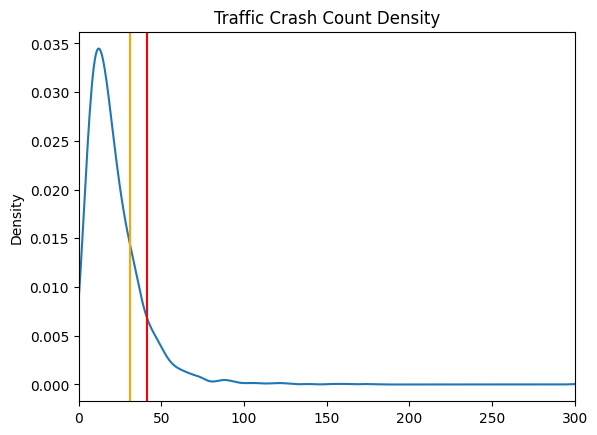

In [107]:
tract_crashes2['count'] = tract_crashes2['count'].astype(int) # ensure no shenanigans
plt = tract_crashes2['count'].plot(kind='density', xlim=(0, 300))
plt.axvline(x=tract_crashes2['count'].quantile(.9), color='red')
plt.axvline(x=tract_crashes2['count'].quantile(.8), color='orange')
plt.set_title("Traffic Crash Count Density")

So let's retry our most successful model on the task with a slightly more expansive cutoff for being a hospot (.8 instead of 0.9)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Model Scored 0.7698924731182796
RF Best Params: {'n_estimators': 200, 'max_depth': 1, 'loss': 'log_loss', 'learning_rate': 0.05}


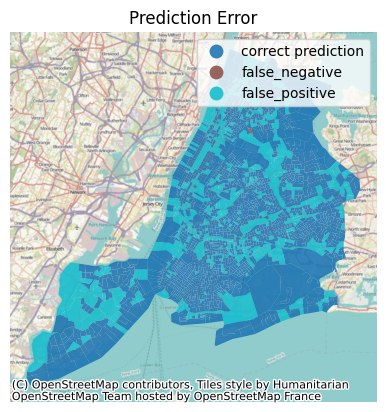

In [110]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gb = {
  'loss': ['exponential', 'log_loss'],
  'learning_rate': [0.05, 0.075, 0.1],
  'n_estimators': [100, 150, 200, 300, 500],
  'max_depth': [1, 3, 5, 7]
}

gb = GradientBoostingClassifier()
rscv = RandomizedSearchCV(estimator=gb,
                          param_distributions=param_grid_gb,
                          n_iter=100, cv=3, verbose=2, n_jobs=-1)

crash_preds, fit_rscv = classify_hotspots(tract_crashes2, rscv, quantile=0.8)

print(f'RF Best Params: {fit_rscv.best_params_}')

map_data_prettierish(crash_preds, error=True)

The resultant model takes a large ding in performance, falling to a 77% accuracy, and now has a false negative. Overall, many of the false positives appear to be shared with prior models (e.g. those in the large census tracts on the southwest of the map). Given that these are false positives, these areas seem to be those where the street network typology alone would hint towards a higher presence of car crashes, but other factors not available to our models seem to be concealing these effects.

To attempt to probe at this further, let's introduce some limited socioeconomic data to the mix. Namely, we add three variables: percent white alone, median gross rent, and population density. All three variables are sourced from or created with variables from the 2022 ACS 5-Year Estimates, which captures COVID variations but is centered on estimates values.

In [112]:
!pip install census

In [124]:
from census import Census
# B25064_001 : Median Gross Rent (Dollars)
# B02001_002 : Estimate!!Total:!!White alone
# B01003_001 : Total Population

# please forgive me for removing my api key after usage
# ive already leaked my openai api key like, twice
# so this is part of my ongoing attempts to Stop
# Leaking API Keys.
c = Census('408751ff847cf81dc08f4093f609e20b7eb6e174')

census = c.acs5.state_county_tract(fields = ('NAME', 'B25064_001E', 'B02001_002E', 'B01003_001E'),
                                   state_fips = '36',
                                   county_fips = "*",
                                   tract = "*")

ny_df = pd.DataFrame(census)

ny_df['GEOID'] = ny_df.apply(lambda x: f"{x['state']}{x['county']}{x['tract']}", axis=1)
ny_df = ny_df.rename({
    'B25064_001E': 'med_gross_rent',
    'B02001_002E': 'white_pop',
    'B01003_001E': 'tot_pop'
}, axis=1)

ny_df['white_per'] = il_df['white_pop'] / il_df['tot_pop']

ny_df = ny_df.drop(['white_pop', 'NAME', 'state', 'county', 'tract'], axis=1)

In [125]:
ny_df.head(3)

,med_gross_rent,tot_pop,GEOID,white_per
0,1019.0,2259.0,36001000100,0.332005
1,999.0,2465.0,36001000201,0.157404
2,753.0,2374.0,36001000202,0.133530


In [136]:
# square mile area
tract_crashes3 = tract_crashes2.copy()
tract_crashes3['sq_mi_ar'] = (tract_crashes3.to_crs('EPSG:2263').area / 2.788 * (10 ** 7))

tract_crashes3 = tract_crashes3.merge(ny_df, on='GEOID')

# ensure no 0 pop tracts or negative rent tracts are present
tract_crashes3 = tract_crashes3[tract_crashes3['tot_pop'] != 0]
tract_crashes3 = tract_crashes3[tract_crashes3['med_gross_rent'] > 0]

tract_crashes3['pop_dens'] = tract_crashes3['tot_pop'] / tract_crashes3['sq_mi_ar']

tract_crashes3 = tract_crashes3.drop(['sq_mi_ar', 'tot_pop'], axis=1)

Model Scored 0.18595142953966404
                        0
-0.250855               0
-0.573373               1
 0.109976               2
-0.519153               3
 0.173113               4
...                   ...
 0.148777             126
 1.131908             127
 0.056897  med_gross_rent
-0.592029       white_per
-0.216069        pop_dens

[131 rows x 1 columns]


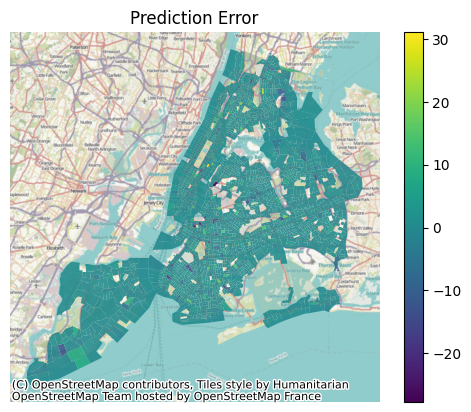

In [154]:
from sklearn.preprocessing import StandardScaler

tract_crashes4 = tract_crashes3.copy()

# Regress first, Classify Second
ss = StandardScaler()
tract_crashes4['pop_dens'] = ss.fit_transform(tract_crashes4[['pop_dens']]).astype(float)
tract_crashes4['med_gross_rent'] = ss.fit_transform(tract_crashes4[['med_gross_rent']]).astype(float)
tract_crashes4.columns = tract_crashes4.columns.astype(str)

# Use RidgeCV for a faster turnaround and coefficients
ridge = RidgeCV()
crash_pred, model = regress_on_counts(tract_crashes4, ridge)

coef_df = pd.DataFrame(tract_crashes4.drop(['geometry', 'GEOID', 'count'], axis=1).columns, model.coef_)
print(coef_df)

map_data_prettierish(crash_pred, error=True)

Just these three variables increased model performance by ~3%, without much additional effort. Note, in particular, that white areas have fewer crashes, and that higher population density results in fewer crashes. Amusingly, gross rent -- a proxy for neigbhorhood niceness -- does not seem to have a strong correlation, although it's correlation _is_ slightly positive.

We now repeat the test for our logistic regression classification task.

Model Scored 0.897025171624714
                        0
 0.000022               0
-0.000286               1
-0.000018               2
-0.000062               3
 0.000191               4
...                   ...
-0.000090             126
 0.000161             127
 0.003992  med_gross_rent
-0.000258       white_per
-0.004389        pop_dens

[131 rows x 1 columns]


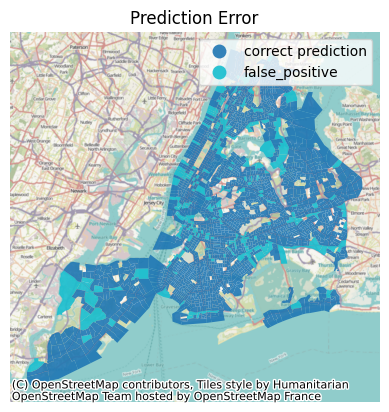

In [165]:
from sklearn.linear_model import LogisticRegressionCV

tract_crashes4 = tract_crashes3.copy()

# Regress first, Classify Second
ss = StandardScaler()
tract_crashes4['pop_dens'] = ss.fit_transform(tract_crashes4[['pop_dens']]).astype(float)
tract_crashes4['med_gross_rent'] = ss.fit_transform(tract_crashes4[['med_gross_rent']]).astype(float)
tract_crashes4.columns = tract_crashes4.columns.astype(str)

logr = LogisticRegressionCV(Cs=15, solver='lbfgs')
hotspot_preds, model = classify_hotspots(tract_crashes4, logr)

coef_df = pd.DataFrame(tract_crashes4.drop(['geometry', 'GEOID', 'count'], axis=1).columns, model.coef_[0])
print(coef_df)

map_data_prettierish(hotspot_preds, error=True)

Including these variables does very little for our logistic regression with regards to hotspot prediction. However, our coefficients are similar to those for the regression -- higher white population percent and population densities correlate with lower chance of being a hotspot, and median gross rent has a slight positive correlation with being a hotspot.

# Reflect

Overall, we find that street network embeddings from Node2Vec offer a potential avenue for capturing and reflecting traffic crash risk at the census tract level. We find that street network topology, as captured by our embeddings, can explain 11-15% of crash counts by itself in our New York City test case, with this explanatory power rising to approximately 18% when considering additional socioeconomic varaibles. When attempting to detect crash hotspots, a logistic regression model using only these embeddings is even capable of acquiring an an 88% test accuracy, albeit with large amounts of false positives. Unfortunately, due to the limited amount of research utilizing network topology to predict crashes, these results are challenging to contextualize. Nonetheless, we have evidence that risk of traffic crash can be captured with surprising accuracy at the zonal level, and without consideration of the specifics of the built environment itself.

Additionally, our results strengthen theories about the influence of racism on modern traffic outcomes and about the influence of population density on outcomes. We find that tracts with higher white populations had fewer traffic crashes, a result that can be explained by white neighborhoods having higher investments over time and hence safer built environments. We additionally found that population density was inversely proportional to traffic crashes, a factor that aligns with prior findings on the influence of population density and crash risk in urban areas.

Looking towards the utility of our Node2Vec approach itself, the largest limitation is likely the relatively black-box nature of the embeddings. While Node2Vec provides 128 feature columns that capture some portion of the street network topology, these feature columns do not have an easily interpretable meaning behind them, making the coefficients on said features hard to interpret. As a result, approaches using this method cannot rely on having clear-cut relationships between their predictive variables and likely outcomes, as would be required for our currently proposed clustering approach. Furthermore, these factors limit the utility of Node2Vec approaches for policy work.

Even with this limitation, in regression approaches -- such as that seen above -- the embeddings can be viewed as capturing meso-scale aspects of the New York City street network, meaning the predictive value of a model trained only on these values would essentially be the "contribution" of meso-scale built environment aspects. Additionally, methods such as Shapley's may be able to allow for easier interpretation of built environment variables.<sup>1</sup>



## Bibliography
Sarkar, C., Webster, C., & Kumari, S. (2018). Street morphology and severity of road casualties: A 5-year study of Greater London. International Journal of Sustainable Transportation, 12(7), 510–525. https://doi.org/10.1080/15568318.2017.1402972

Tran, T., He, D., Kim, J., & Hickman, M. (2023). MSGNN: A Multi-structured Graph Neural Network model for real-time incident prediction in large traffic networks. Transportation Research Part C: Emerging Technologies, 156, 104354. https://doi.org/10.1016/j.trc.2023.104354

Wang, M., Lee, W.-C., Fu, T., & Yu, G. (2019). Learning Embeddings of Intersections on Road Networks. Proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, 309–318. https://doi.org/10.1145/3347146.3359075

Wang, M.-X., Lee, W.-C., Fu, T.-Y., & Yu, G. (2020). On Representation Learning for Road Networks. ACM Transportation Intelligence Systems Technology, 12(1), 11:1-27. https://doi.org/10.1145/3424346


### Footnotes
<sup>1</sup>_This sentence has resulted in me realizing that there is actually a really fun potential research design where I use Shapley's -- or another interpretable machine learning method -- to investigate the relationship between health outcomes, HOLC, and the risk environment. It wouldn't result in a typology but I don't think all risk environment work needs to do so._